In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import sys
%matplotlib inline

In [2]:
plt.style.use('ggplot')

In [3]:
from skimage.data import astronaut

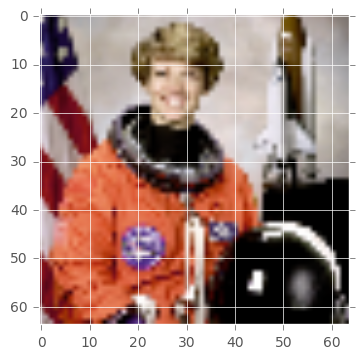

In [5]:
img = cv2.resize(astronaut(), (64,64))
plt.imshow(img)

In [7]:
def split_image(img):
    
    xs = []
    ys = []
    
    for row_i in range(img.shape[0]):
        for col_i in range(img.shape[1]):
            
            xs.append([row_i, col_i])
            ys.append(img[row_i, col_i])
         
    xs = np.array(xs)
    ys = np.array(ys)
    return xs, ys

In [22]:
def linear(x, n_output, name=None, activation=None, reuse=None):
    """Fully connected layer

    Parameters
    ----------
    x : tf.Tensor
        Input tensor to connect
    n_output : int
        Number of output neurons
    name : None, optional
        Scope to apply

    Returns
    -------
    op : tf.Tensor
        Output of fully connected layer.
    """
    if len(x.get_shape()) != 2:
        x = flatten(x, reuse=reuse)

    n_input = x.get_shape().as_list()[1]

    with tf.variable_scope(name or "fc", reuse=reuse):
        W = tf.get_variable(
            name='W',
            shape=[n_input, n_output],
            dtype=tf.float32,
            initializer=tf.contrib.layers.xavier_initializer())

        b = tf.get_variable(
            name='b',
            shape=[n_output],
            dtype=tf.float32,
            initializer=tf.constant_initializer(0.0))

        h = tf.nn.bias_add(
            name='h',
            value=tf.matmul(x, W),
            bias=b)

        if activation:
            h = activation(h)

        return h, W

In [9]:
xs, ys = split_image(img)
xs.shape, ys.shape

((4096, 2), (4096, 3))

In [10]:
xs = (xs - np.mean(xs)) / np.std(xs)

In [13]:
ys = ys / 255.

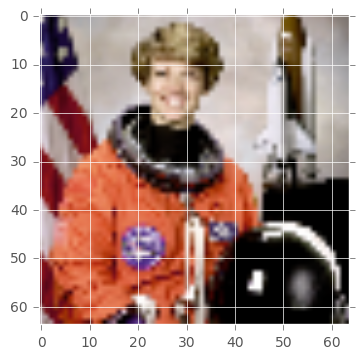

In [14]:
plt.imshow(ys.reshape(img.shape))

In [16]:
tf.reset_default_graph()

X = tf.placeholder(dtype = tf.float32, shape = [None, 2], name = 'X')

Y = tf.placeholder(dtype = tf.float32, shape = [None, 3], name = 'Y')

In [24]:
n_neurons = 20

h1, W1 = linear(X, n_neurons, activation = tf.nn.relu, name = 'layer1')
h2, W2 = linear(h1, n_neurons, activation = tf.nn.relu, name = 'layer2')
h3, W3 = linear(h2, n_neurons, activation = tf.nn.relu, name = 'layer3')
h4, W4 = linear(h3, n_neurons, activation = tf.nn.relu, name = 'layer4')
h5, W5 = linear(h4, n_neurons, activation = tf.nn.relu, name = 'layer5')
h6, W6 = linear(h2, n_neurons, activation = tf.nn.relu, name = 'layer6')

Y_pred, W7 = linear(h6, 3, activation = None, name = 'pred')

In [27]:
Y_pred.get_shape().as_list()

[None, 3]

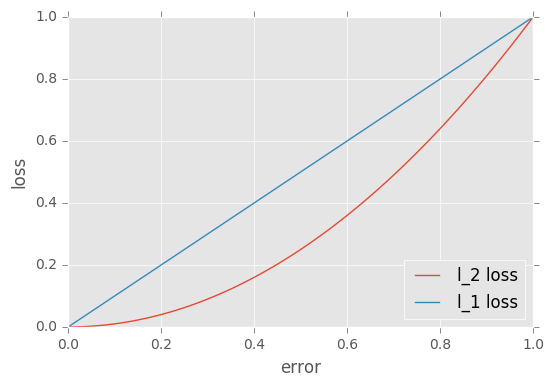

In [28]:
error = np.linspace(0.0, 1.0, 100)
plt.plot(error, error**2, label='l_2 loss')
plt.plot(error, np.abs(error), label='l_1 loss')
plt.xlabel('error')
plt.ylabel('loss')
plt.legend(loc='lower right')

In [30]:
def l1_norm(x1, x2):
    return tf.abs(x1 - x2)

In [33]:
error = l1_norm(Y_pred, Y)
assert(error.get_shape().as_list() == [None, 3])

In [35]:
sum_error = tf.reduce_sum(error, 1)
assert(sum_error.get_shape().as_list() == [None])

In [36]:
cost = tf.reduce_mean(sum_error)
assert(cost.get_shape().as_list() == [])

In [39]:
optimizer = tf.train.AdamOptimizer(1e-4).minimize(cost)

n_iterations = 2000

batch_size = 200

sess = tf.Session()

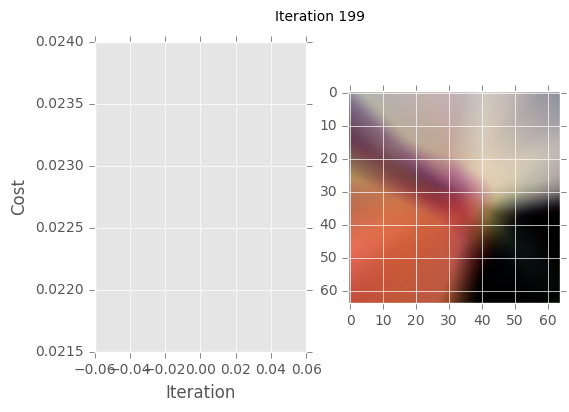

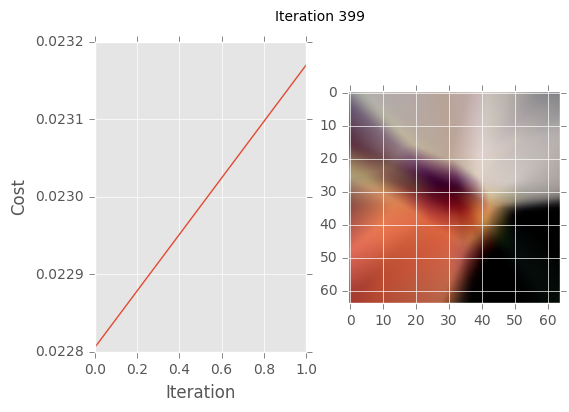

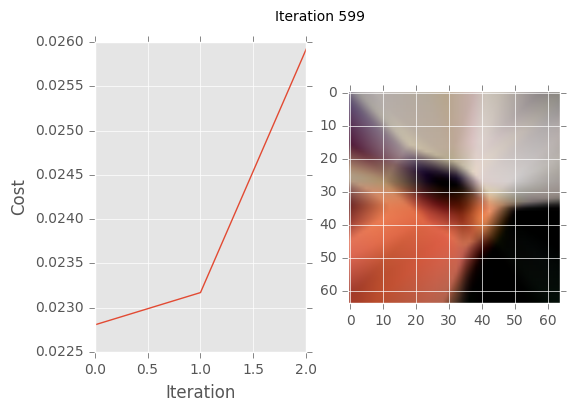

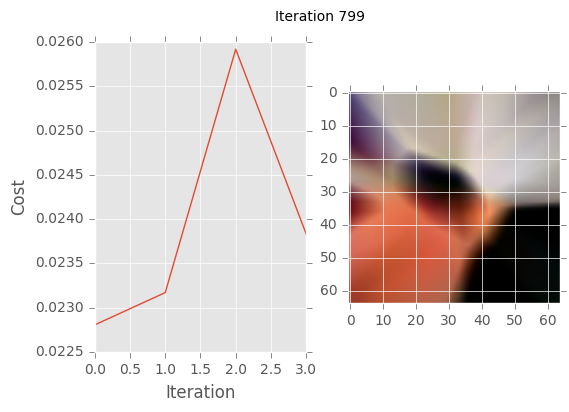

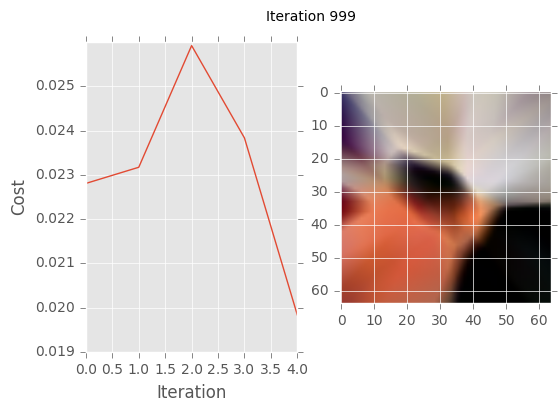

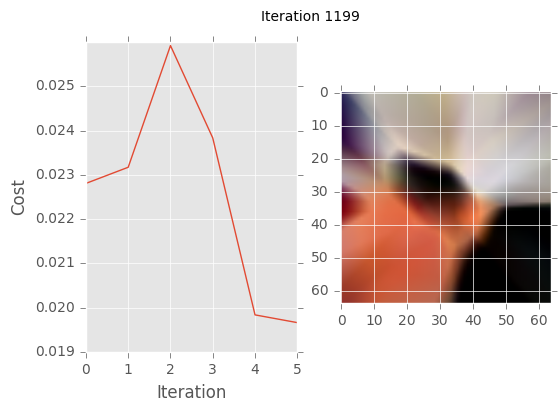

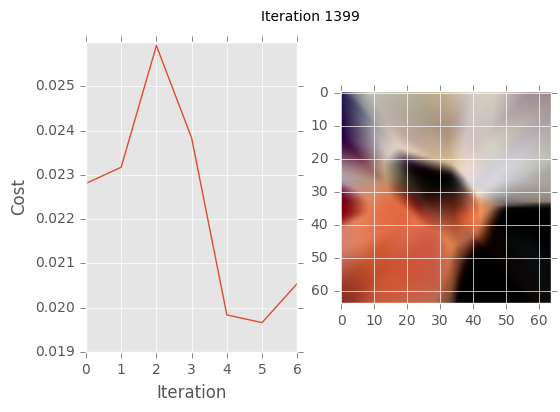

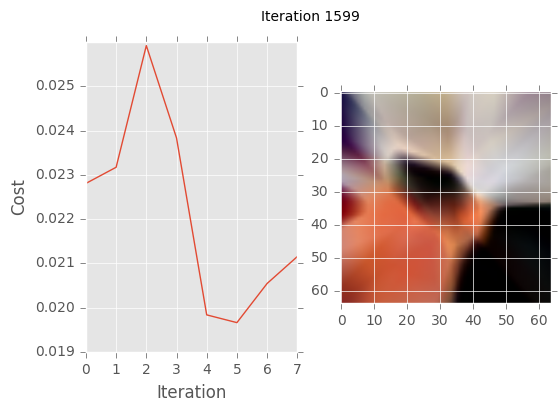

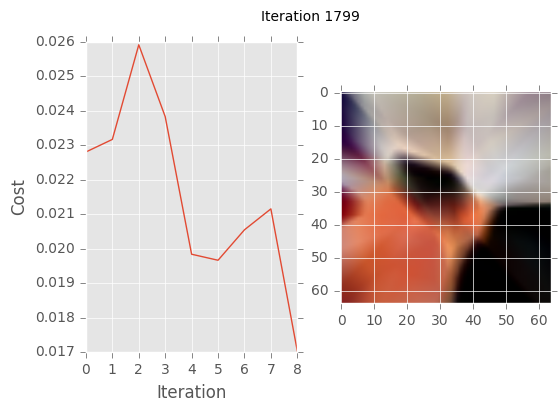

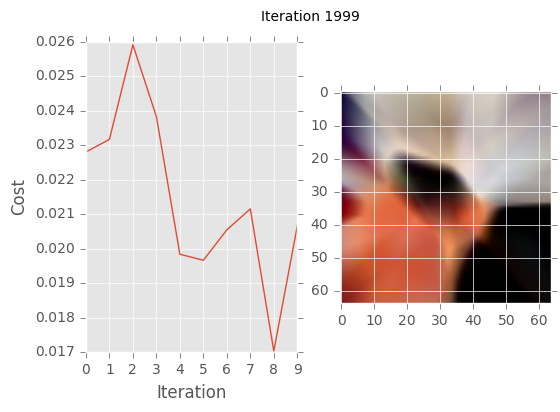

In [40]:
sess.run(tf.global_variables_initializer())

imgs = []
costs = []
gif_step = n_iterations // 10
step_i = 0

for it_i in range(n_iterations):
    
    idxs = np.random.permutation(range(len(xs)))
    n_batches = len(idxs) // batch_size
    
    for batch_i in range(n_batches):
        idxs_i = idxs[batch_i * batch_size : (batch_i + 1) * batch_size]
        training_cost = sess.run([cost, optimizer], feed_dict = {X: xs[idxs_i], Y: ys[idxs_i]})[0]
        
        
    if (it_i + 1) % gif_step == 0:
        costs.append(training_cost / n_batches)
        ys_pred = Y_pred.eval(feed_dict={X: xs}, session=sess)
        img = np.clip(ys_pred.reshape(img.shape), 0, 1)
        imgs.append(img)
        # Plot the cost over time
        fig, ax = plt.subplots(1, 2)
        ax[0].plot(costs)
        ax[0].set_xlabel('Iteration')
        ax[0].set_ylabel('Cost')
        ax[1].imshow(img)
        fig.suptitle('Iteration {}'.format(it_i))
        plt.show()